In [69]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Données

In [70]:
df = pd.read_csv("ozone.csv")
df = df.drop([df.columns[0]], axis=1) # supprime colonne inutile
df.head()

JOUR  O3obs  MOCAGE  TEMPE    RMH2O    NO2     NO STATION  VentMOD  VentANG
0   1.0   91.0    93.2   21.5  0.00847  1.602  0.424     Aix   9.5000 -0.64350
1   1.0  100.0   104.6   20.2  0.00881  2.121  0.531     Aix   8.0100 -0.04996
2   0.0   82.0   103.6    NaN  0.00951  1.657  0.467     Aix   9.3771 -0.12832
3   0.0   94.0    94.8   18.8  0.00855  2.350  0.701     Aix   9.4578 -0.34516
4   0.0  107.0    99.0   23.7  0.00731    NaN  0.452     Aix   7.8791 -0.41822

In [71]:
from sklearn.model_selection import train_test_split

# on garde un échantillon de 20% pour le test qu'on ne touchera jamais
X_train, X_test = train_test_split(df,test_size=0.2, random_state=42)

# On récupère la colonne cible O3obs
Y_train = X_train['O3obs']
Y_test = X_test['O3obs']

X_train = X_train.drop('O3obs', axis=1)
X_test = X_test.drop('O3obs', axis=1)

In [72]:
X_train.describe()

JOUR      MOCAGE       TEMPE       RMH2O         NO2          NO  \
count  787.000000  804.000000  715.000000  785.000000  787.000000  794.000000   
mean     0.289708  126.327736   23.862378    0.010212    3.460564    0.656505   
std      0.453915   39.857537    5.195680    0.003794    4.099449    0.844841   
min      0.000000   46.400000   10.400000    0.002850    0.258000    0.052000   
25%      0.000000   96.550000   20.200000    0.007460    1.192000    0.230250   
50%      0.000000  123.950000   23.700000    0.009800    2.058000    0.386000   
75%      1.000000  153.500000   27.600000    0.012410    3.920500    0.752500   
max      1.000000  284.700000   38.000000    0.027530   44.396000    9.429000   

          VentMOD     VentANG  
count  792.000000  785.000000  
mean     5.928133    0.154784  
std      3.154396    0.704786  
min      0.141420   -1.570790  
25%      3.914093   -0.398960  
50%      5.514965    0.251690  
75%      7.137025    0.706610  
max     19.891000    1.570790

In [73]:
Y_train.describe()

count    795.000000
mean     115.320755
std       40.977957
min       19.000000
25%       87.000000
50%      109.000000
75%      135.000000
max      319.000000
Name: O3obs, dtype: float64

In [74]:
print(f"Le nombre de NaN pour chaque variable pour nos {len(X_train)} données")
len(X_train)-X_train.count() 

Le nombre de NaN pour chaque variable pour nos 832 données


JOUR        45
MOCAGE      28
TEMPE      117
RMH2O       47
NO2         45
NO          38
STATION     47
VentMOD     40
VentANG     47
dtype: int64

Seul la variable STATION a des données non numériques donc on les transforme

In [75]:
from sklearn.preprocessing import LabelEncoder

mask = X_train['STATION'].notna() # on garde les NaN
label_encoder = LabelEncoder()
X_train.loc[mask, 'STATION'] = label_encoder.fit_transform(X_train.loc[mask,'STATION'])
print(X_train['STATION'])

634    4
381    1
506    2
693    4
874    3
      ..
87     0
330    1
466    2
121    0
860    3
Name: STATION, Length: 832, dtype: object


In [76]:
print("Nombre de colonne avec au moins un NaN", X_train.isna().any(axis=1).sum())

Nombre de colonne avec au moins un NaN 358


In [77]:
col = X_train.columns
col_disc = ["JOUR", "STATION"] # colonnes à valeurs discretes
col_cont = col.drop(col_disc) # colonnes à valeurs continues

On a donc un dataset de **832** données, c'est-à-dire un bon ordre de grandeur. Celle-ci sont tout de même affectées par les NaN présents sur 380 observations. 

Nous souhaitons prédire la variable ``O3obs`` continue selon la métrique RMSE.  
Pour ce faire, nous avons,  
+ 7 var. continues : `MOCAGE`, `TEMPE`, `RMH2O`, `NO2`, `NO`, `VentMOD`,`VentANG`  
+ 2 var. discrètes : `JOUR`,`STATION`

Mis à part `VentANG` toutes nos variables explicatives sont positives.

# Visualisation des données

### Visualisation des variables continues

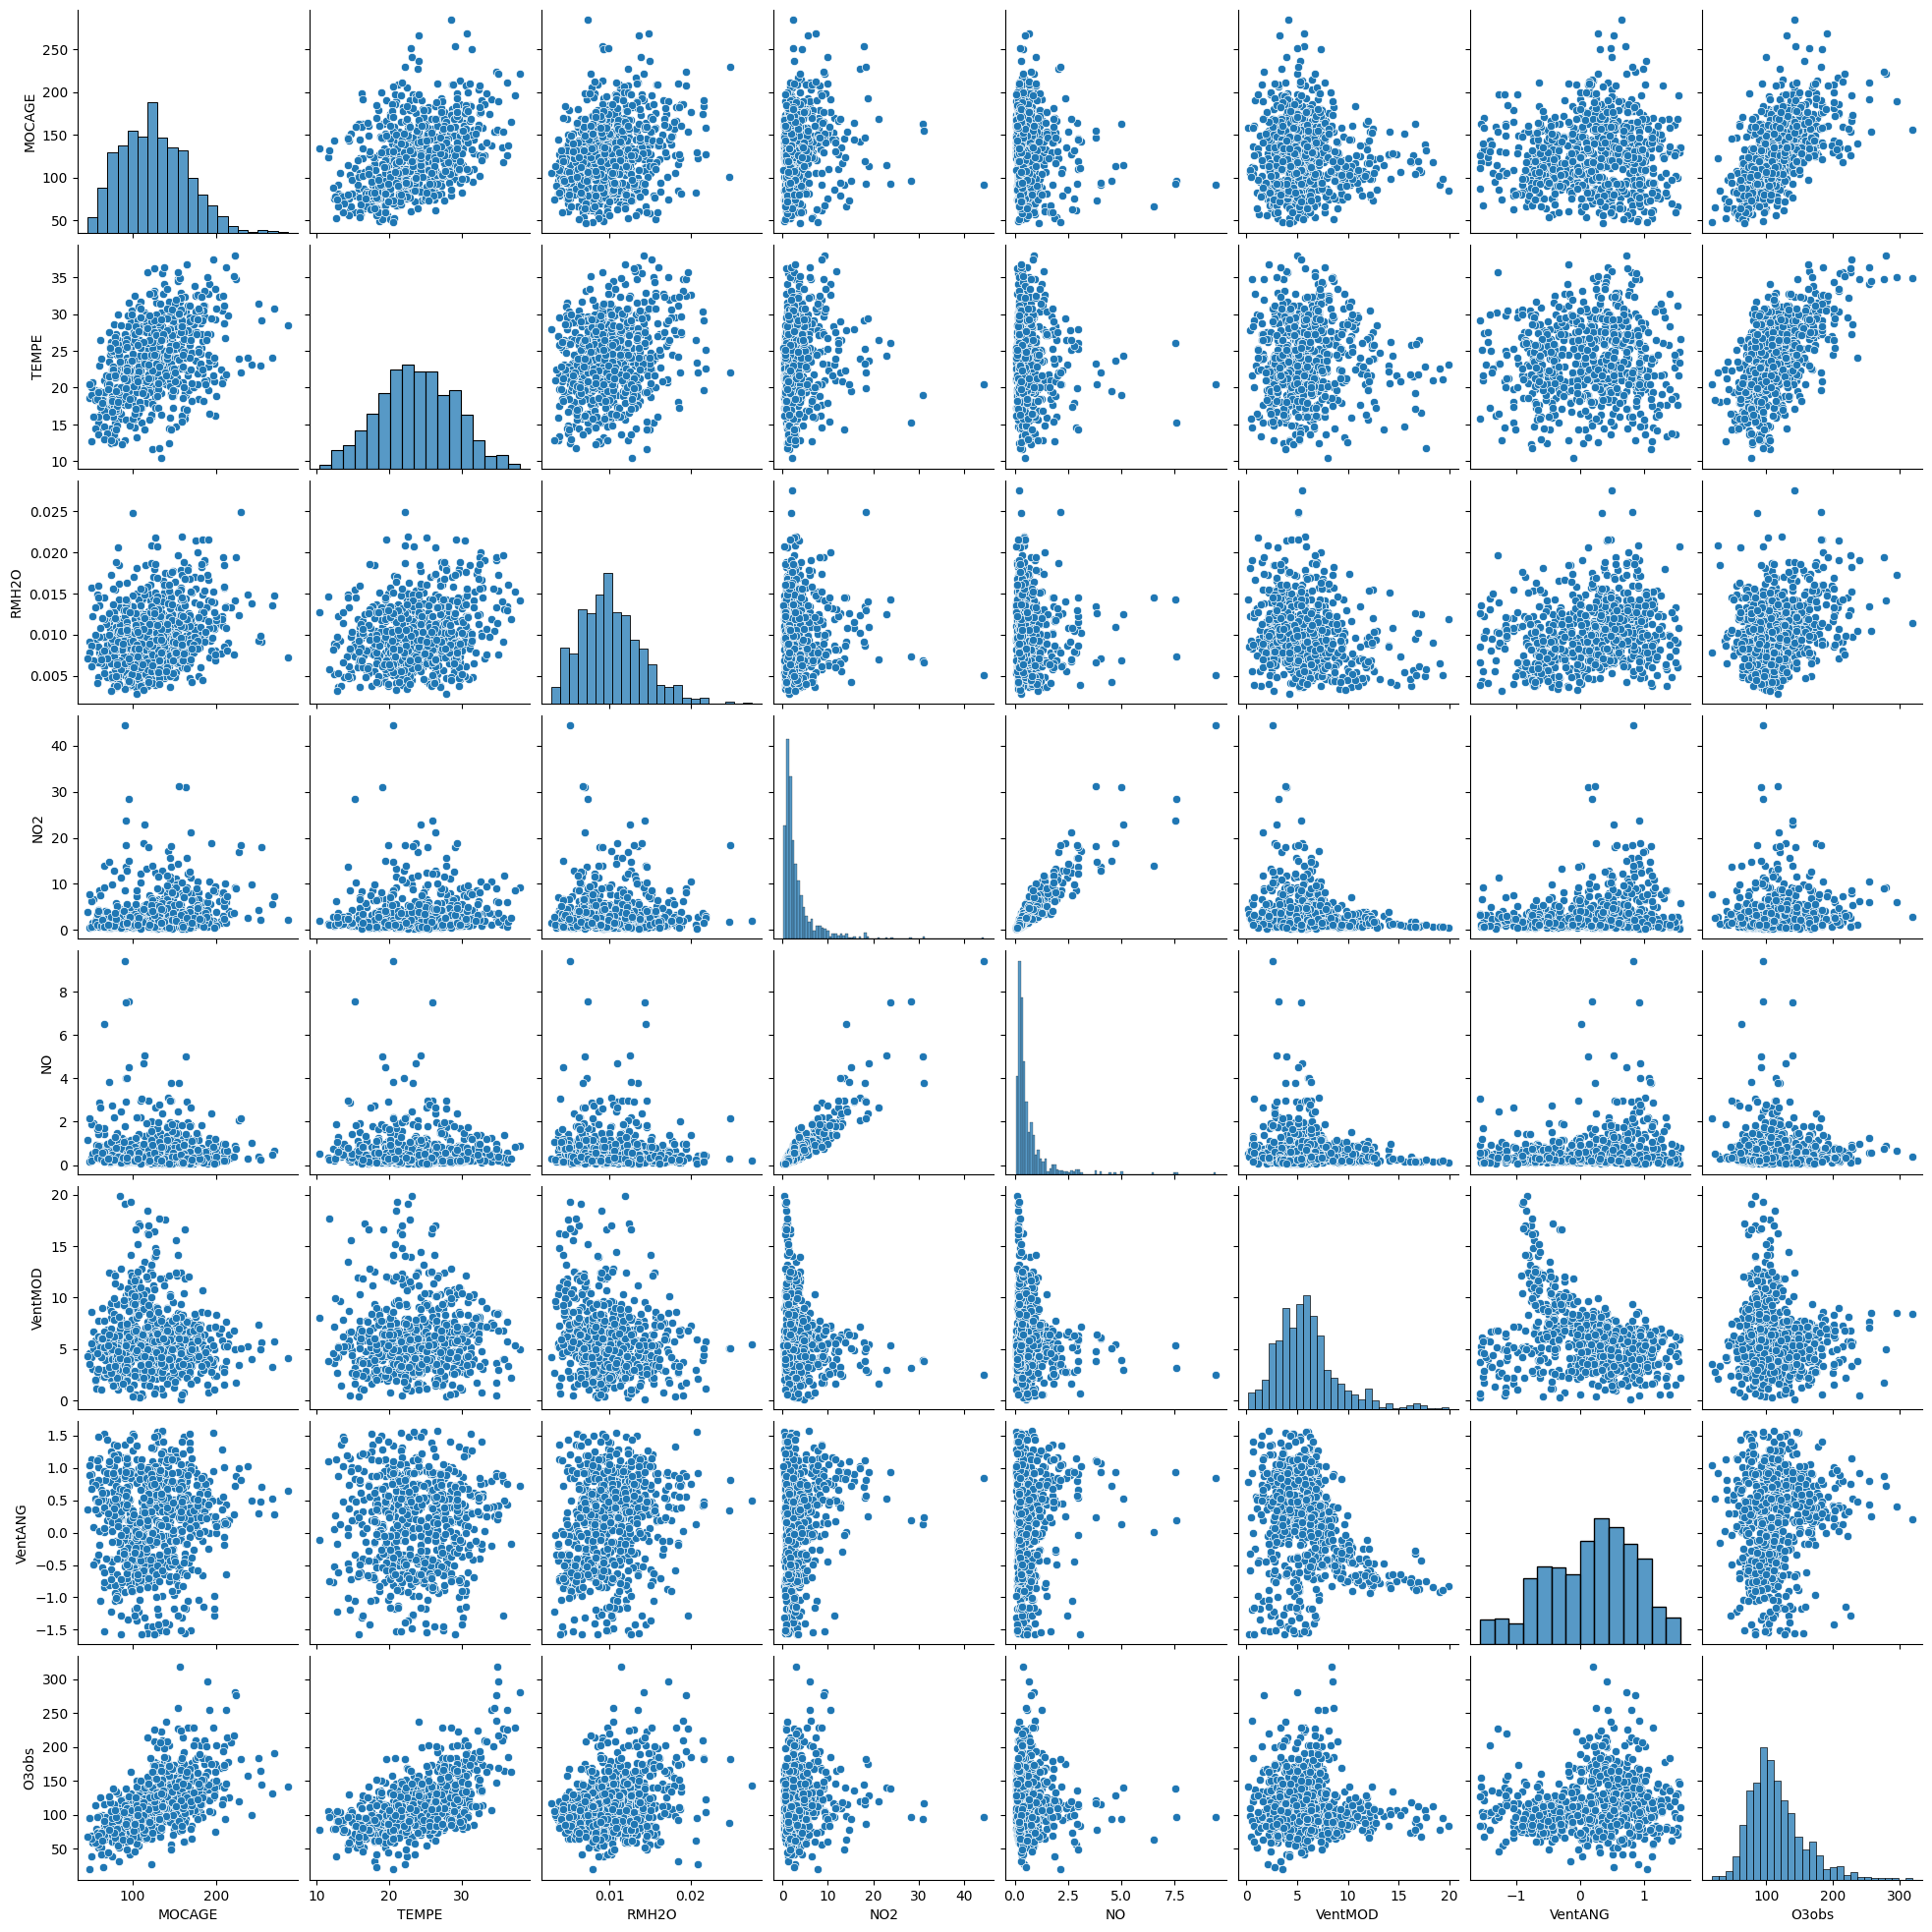

In [78]:
sns.pairplot(pd.concat([X_train[col_cont], Y_train], axis=1))

### Visualisation des variables discrètes

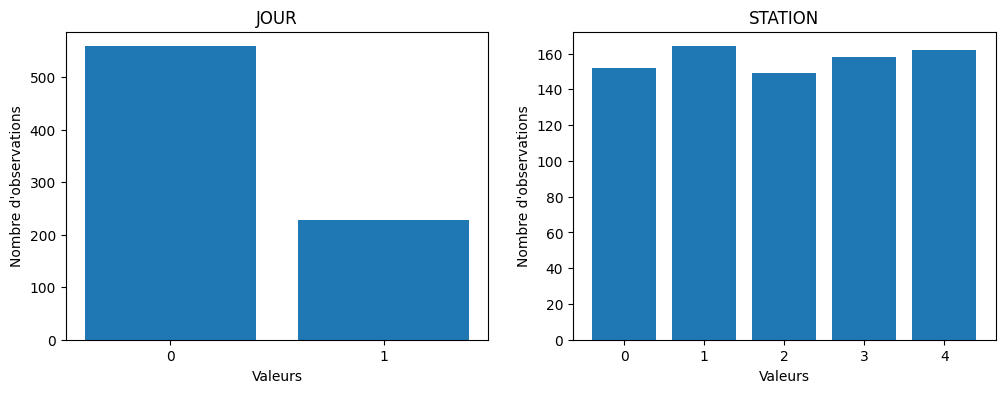

In [79]:
fig, axes = plt.subplots(1, len(col_disc), figsize=(12, 4))

for ax, col in zip(axes, col_disc):
    val = X_train[col].dropna()
    
    bins = np.arange(min(val) - 0.5, max(val) + 1.5) # pour centrer les ticks
    ax.hist(val, bins=bins, align='mid', rwidth=0.8)

    ax.set_title(col)
    ax.set_xlabel('Valeurs')
    ax.set_ylabel("Nombre d'observations")
    ax.set_xticks(np.arange(min(val), max(val) + 1))

plt.show()


### Visualisation des variables continues selon les discrètes

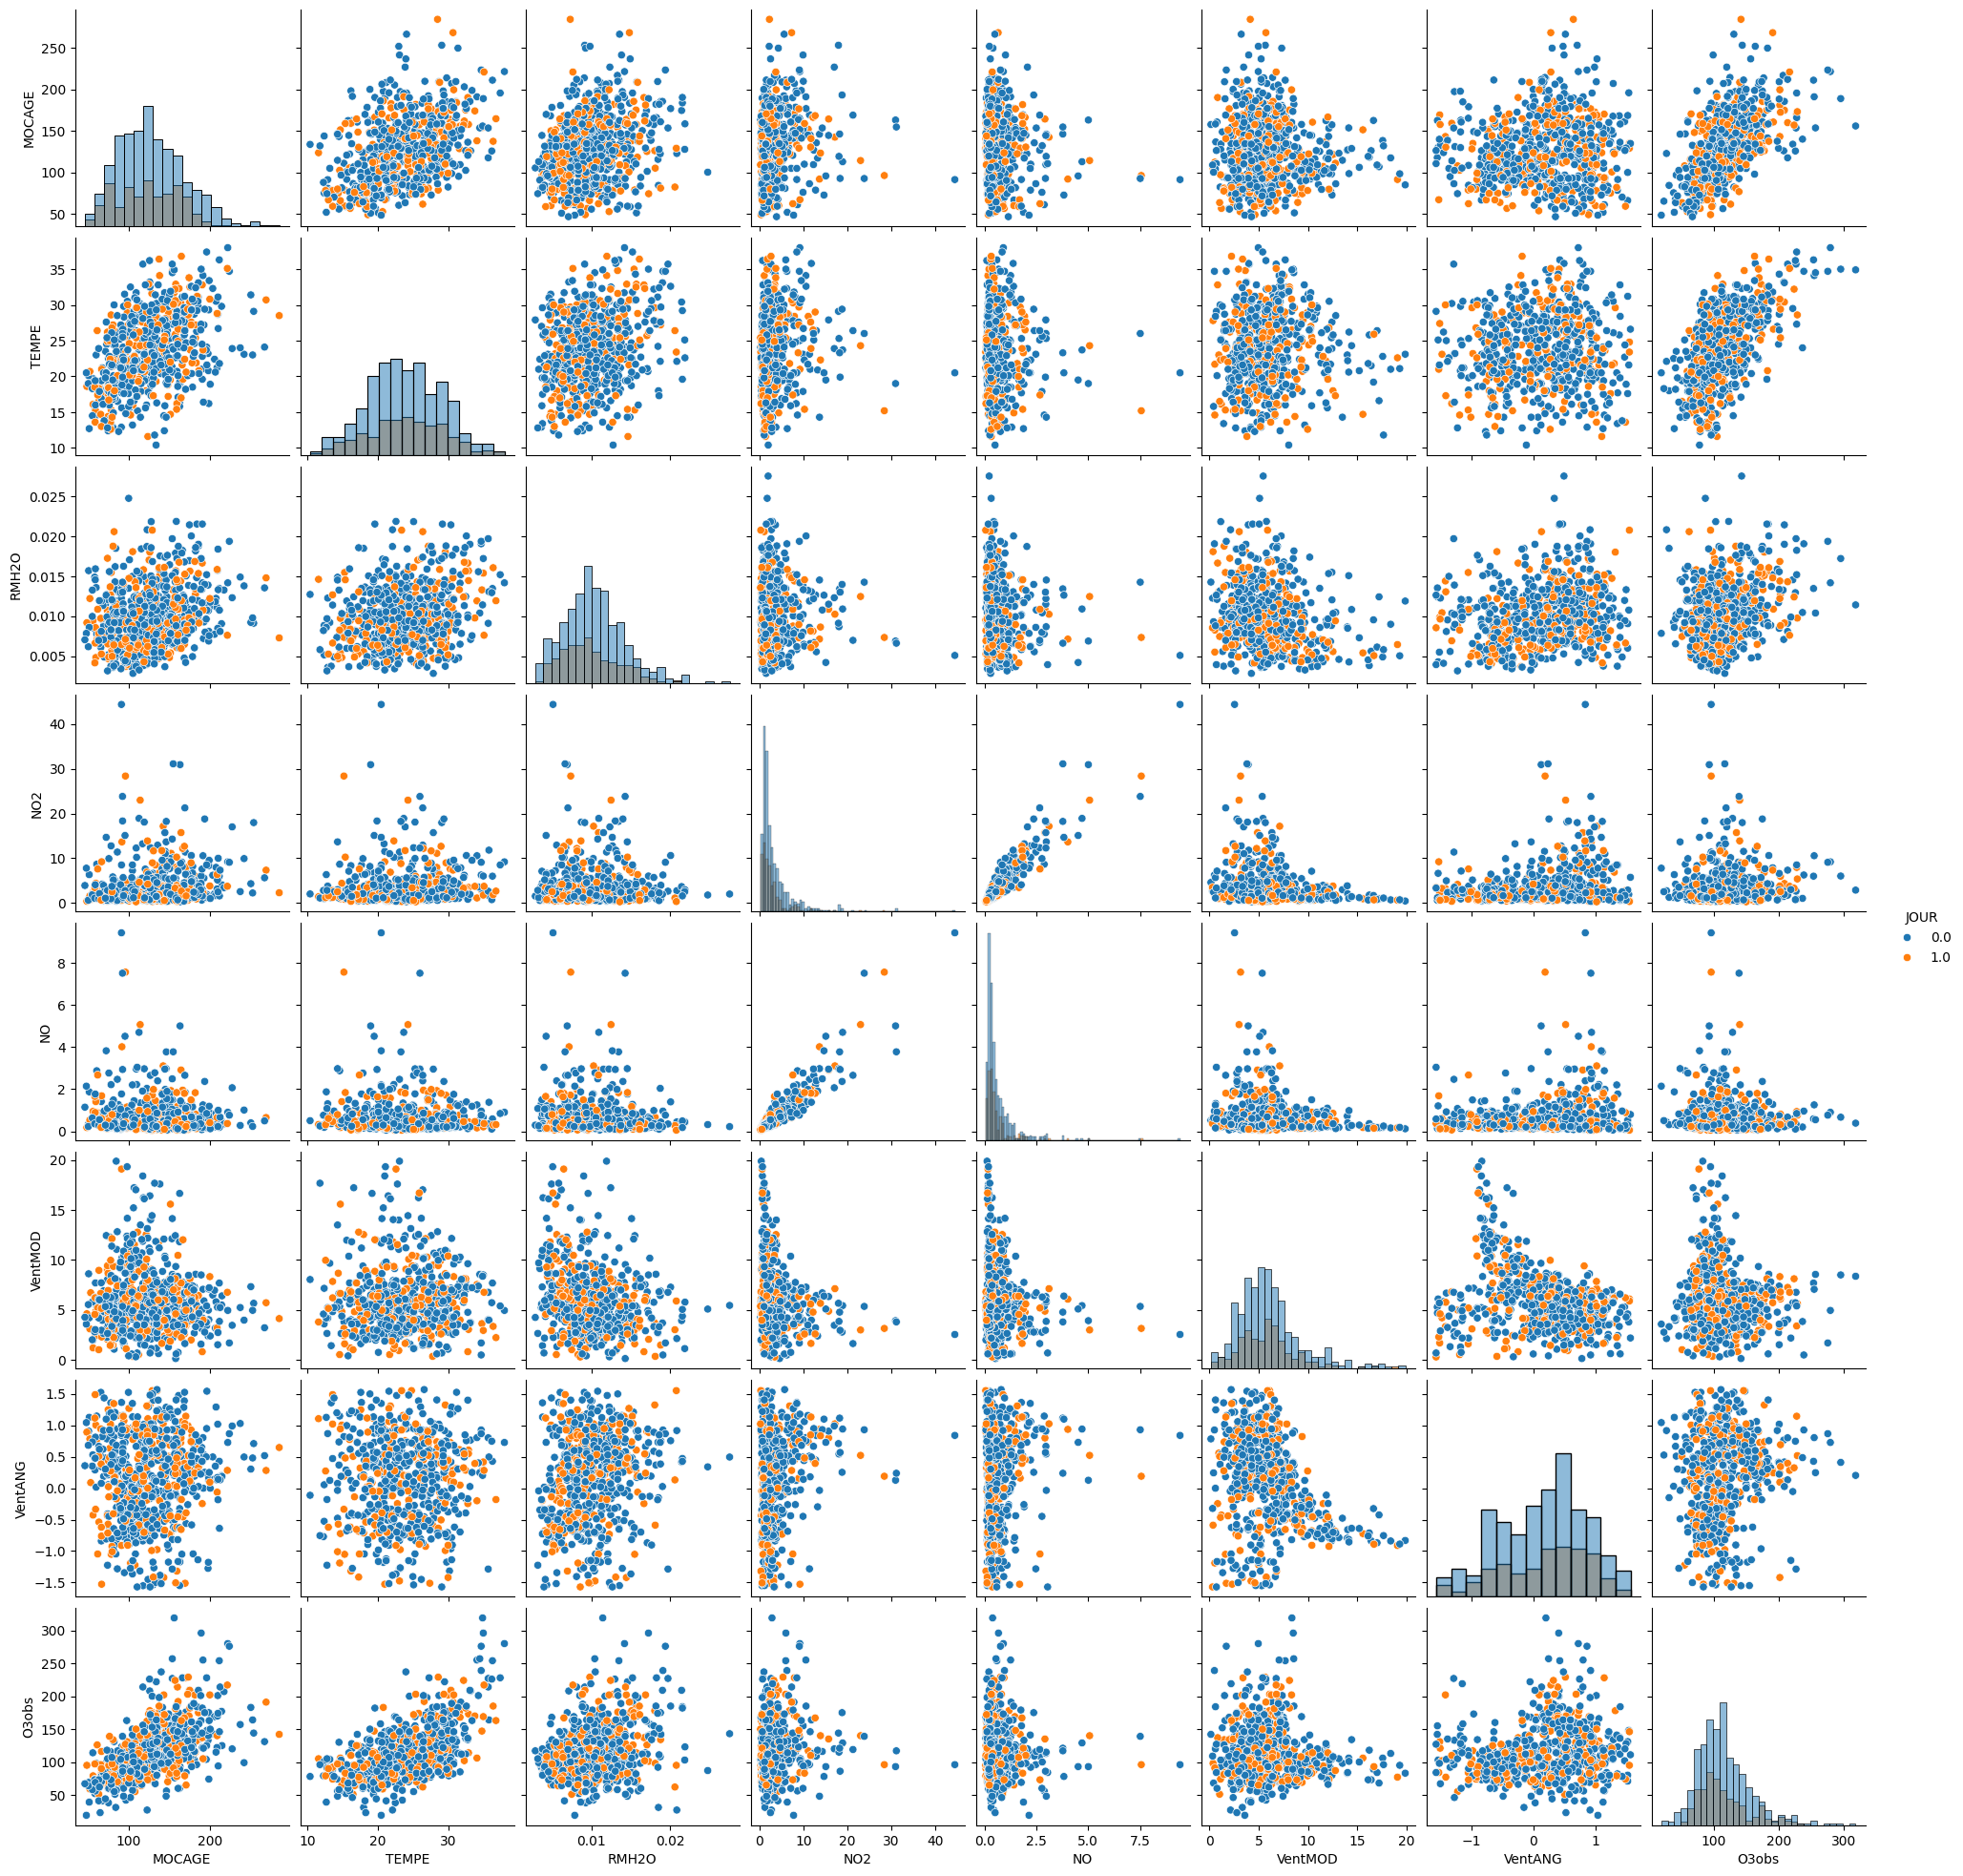

In [80]:
sns.pairplot(pd.concat([X_train, Y_train], axis=1), vars=list(col_cont)+['O3obs'],  hue="JOUR",diag_kind="hist")

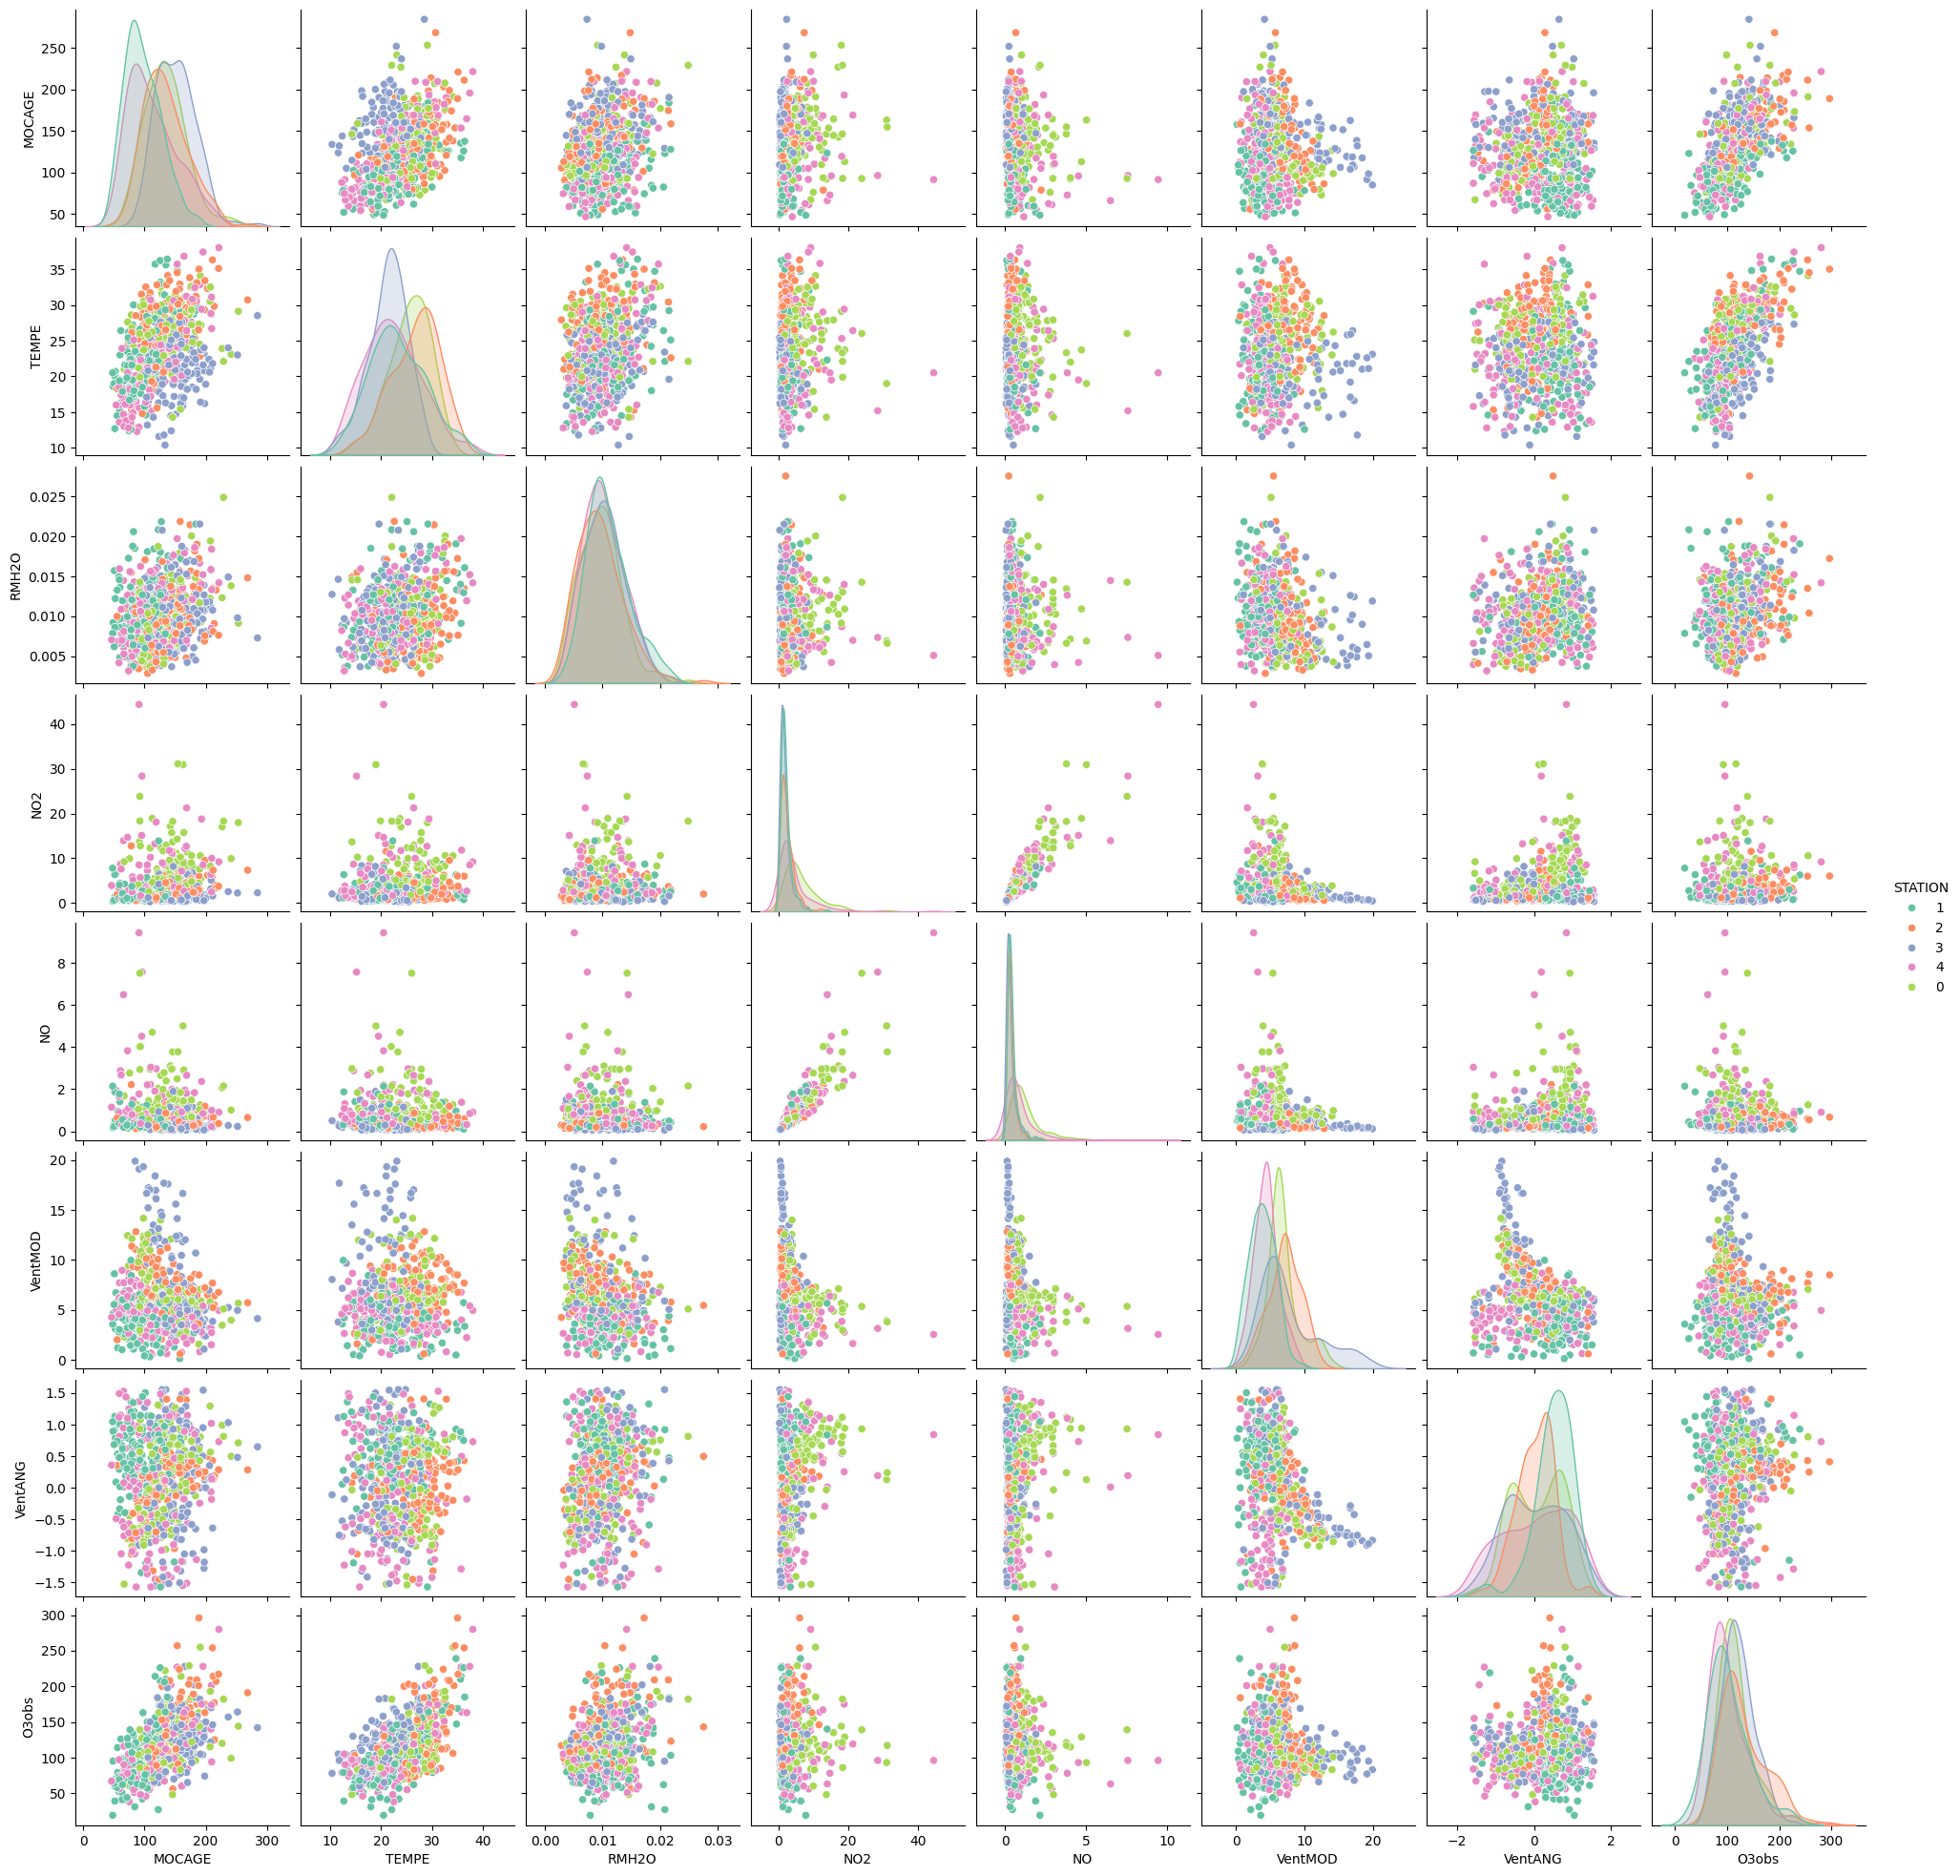

In [81]:
# kde car on voit rien avec hist et Set2 car par défautt on voit rien
sns.pairplot(pd.concat([X_train, Y_train], axis=1),vars=list(col_cont)+["O3obs"],hue="STATION",diag_kind="kde", palette="Set2" )

## Remarque

+ La variable TEMPE semble suivre une loi normale : cohérent avec la réalité.
+ Les variables NO2 et NO semblent suivre une loi exponentielle.
+ Les variables 03OBS, MOCAGE RMH2O semblent à avoir une "right skewness" (asymétrie à droite).
+ Les variables restantes : VentMOD, VentANG restent à déterminer
+ Les jours ne sont pas sont distribués de manière équilibrée (plus de jours pas fériés (0) que de jours féries (1))
+ Les mesures sont réalisés dans des stations de manière uniforme

+ Il semblerait que les JOURS n'influent pas sur la distribution des données.
+ Le lieu de station est lié (à voir comment) avec les autres données. Exemple : la station 1 semble avoir tendance à avoir plus de ventANG et moins de MOCAGE ou encore la 3 semble être peu étendue selon NO2 et NO

+ Au vu des noms et de leur distribution, N0 et N02 sont fortement liés comme ventMOD et ventANG.

# Scores sur dataset basiques

Nous allons définir des modèles simples très généraux afin de voir la performance sur nos données sans (au quasiment) aucun traitement.

## Suppresion naïve des NaN

Afin de faire ce test on supprime toutes les données avec les NaN. Nous verrons par la suite comment les gérer.

In [82]:
# on travaille sur X_train_simple afin de protéger les données
X_train_simple = X_train.copy() 
Y_train_simple = Y_train.copy()

In [83]:
print("Le nombre de NaN dans la variable cible est de", len(Y_train)-Y_train.count())
X_train_simple = X_train_simple[Y_train.notna()]
Y_train_simple = Y_train_simple[Y_train.notna()]

# supprimer tous les NaN venant de X_train
Y_train_simple = Y_train_simple[X_train_simple.notna().all(axis=1)]
X_train_simple = X_train_simple[X_train_simple.notna().all(axis=1)]

print(f"Nous avons {len(X_train_simple)} observations et {len(X_train_simple.columns)} variables")

Le nombre de NaN dans la variable cible est de 37
Nous avons 452 observations et 9 variables


En regardant la base de données df, on remarque que les données sont rangées selon les stations, donc si on évalue un modèle dans l'ordre il y aura un biais induit par les prmeières stations sur lesquelles il aura appris.
De plus pour la cross validaiton, en 80/20, il se peut que l'ensemble de validation soit à propos de stations jamais rencontrées.
On mélange donc les données (et la cible par conséquent !)

In [84]:
from sklearn.utils import shuffle

X_train_simple, Y_train_simple = shuffle(X_train_simple, Y_train_simple, random_state=42)

## Modèles simples

In [85]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

In [86]:
# random_state pour la reproductibilité, qu'on ait toujours les memes résultats (meme aléatoire)
models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Lasso' : Lasso(random_state=42),
    'Ridge' : Ridge(random_state=42),
    'Linear': LinearRegression()
}

In [87]:
def test_model_simple(X,Y):
    for name, model in models.items():
        # on fait une cross_val_score afin d'avoir un estimation de la performance du modèle
        rmse = cross_val_score(model, X, Y, cv=5, scoring='neg_root_mean_squared_error')
        rmse = -rmse # car c'etait negatif
        print(f"{name:10s} RMSE: {rmse.mean():.3f} ± {rmse.std():.3f}")

In [88]:
test_model_simple(X_train_simple, Y_train_simple)

KNN        RMSE: 31.176 ± 2.630
Lasso      RMSE: 27.433 ± 2.200
Ridge      RMSE: 27.311 ± 1.689
Linear     RMSE: 27.374 ± 1.734


On se trompe de la bonne valeur d'un ordre de 27 en moyenne. C'est raisonnable comme première approximation puisque la variable cible se trouve entre 19 et 319 mais faisons mieux !  

On a maintenant un score général sur nos données presque comme si on ne les avait pas modifiées. Améliorons ces scores de test références afin que nos données nous révèlent plus d'informations.

# Nettoyage de données

In [89]:
# on travaille sur X_train_clean avec des colonnes modifiées afin d'améliorer les prédictions
X_train_clean = X_train.copy() 
Y_train_clean = Y_train.copy()

In [90]:
print("Le nombre de NaN dans la variable cible est de", len(Y_train)-Y_train.count())
X_train_clean = X_train_clean[Y_train.notna()]
Y_train_clean = Y_train_clean[Y_train.notna()]

Le nombre de NaN dans la variable cible est de 37


De par le peu de nombre de NaN dans la colonne cible, on préfère les supprimer.
On souhaite prédire ces valeurs donc ça n'a pas de sens de leur imputer une valeur nous même ! De plus ces données représentent moins de 5% (37/832) de notre ensemble d'entrainement, c'est relativement insignifiant.

## NaN

In [91]:
print("Nombre d'observations avec au moins un NaN : ", X_train_clean.isna().any(axis=1).sum())

Nombre d'observations avec au moins un NaN :  343


On cherche une manière de remplacer les NaN.
Pour les valeurs continues on utilise soit la moyenne, soit la médiane, soit KNN avec un certains nombre de voisins.
Pour les variables discrètes, afin de garder la cohérence dans les données (qu'elles soient toujours discrètes) on arrondi à la valeur la plus proche.

In [92]:
from sklearn.impute import SimpleImputer, KNNImputer

strategies = {       
    'mean' : SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'knn1': KNNImputer(n_neighbors=1),
    'knn3': KNNImputer(n_neighbors=3),
    'knn5': KNNImputer(n_neighbors=5),
    'knn7': KNNImputer(n_neighbors=7),
    'knn10': KNNImputer(n_neighbors=10)
}

for name, imputer in strategies.items():
    print(f"Remplace les NaN par {name}")
    X_imp = imputer.fit_transform(X_train_clean)
    X_tmp = pd.DataFrame(X_imp, columns=X_train_clean.columns, index=X_train_clean.index)
    X_tmp[col_disc] = X_tmp[col_disc].round().astype(int)
    Y_tmp = Y_train_clean
    test_model_simple(X_tmp, Y_tmp)

Remplace les NaN par mean
KNN        RMSE: 30.042 ± 1.885
Lasso      RMSE: 29.153 ± 2.147
Ridge      RMSE: 29.166 ± 2.194
Linear     RMSE: 29.165 ± 2.131
Remplace les NaN par median
KNN        RMSE: 30.249 ± 2.352
Lasso      RMSE: 29.165 ± 2.146
Ridge      RMSE: 29.171 ± 2.177
Linear     RMSE: 29.168 ± 2.108
Remplace les NaN par knn1
KNN        RMSE: 30.280 ± 1.691
Lasso      RMSE: 29.363 ± 2.415
Ridge      RMSE: 29.440 ± 2.437
Linear     RMSE: 29.349 ± 2.411
Remplace les NaN par knn3
KNN        RMSE: 29.698 ± 1.493
Lasso      RMSE: 28.880 ± 2.318
Ridge      RMSE: 28.857 ± 2.339
Linear     RMSE: 28.849 ± 2.284
Remplace les NaN par knn5
KNN        RMSE: 29.767 ± 1.383
Lasso      RMSE: 28.780 ± 2.167
Ridge      RMSE: 28.738 ± 2.184
Linear     RMSE: 28.743 ± 2.127
Remplace les NaN par knn7
KNN        RMSE: 29.751 ± 1.237
Lasso      RMSE: 28.745 ± 2.107
Ridge      RMSE: 28.727 ± 2.141
Linear     RMSE: 28.732 ± 2.074
Remplace les NaN par knn10
KNN        RMSE: 29.815 ± 1.736
Lasso      RMSE

On choisit au vu des scores, KNN avec 7 voisins. Ce choix n’est pas déterminant, puisque les RMSE varient très peu. Meme, il permet de conserver l’intégralité des 795 observations au lieu de n’en garder que 489 ! On gagne de l'information pour la suite.

In [93]:
X_train_clean = pd.DataFrame(KNNImputer(n_neighbors=7).fit_transform(X_train_clean),columns=X_train_clean.columns,index=X_train_clean.index)
X_train_clean[col_disc] = X_train_clean[col_disc].round().astype(int)

## Skewness

Nous allons "redresser" l'asymétrie des distribution afin de revenir à un cas "normal" largement 
https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation

Une méthode couramment utilisée et qui dans notre cas fonctionne à merveille est Box-Col qui demande aux vairbales d'être positives, ce qui est le cas!

On souhaite enlever cette asymétrie car la plupart des modèles suppose que nos données soient normales et cela permet de se rapprocher de cette hyptohèse et donc d'améliorer la qualité de l'analyse.

In [94]:
from scipy import stats

def test_normalite(data):
    for colonne in data.columns:
        stat, p_val = stats.shapiro(data[colonne])
        est_normal = p_val >0.05 # resultat du test

        print(f"{colonne} - stat={stat:.3f}, p-valeur={p_val:.3f}, resultat (normal ?)={est_normal}")

In [95]:
test_normalite(X_train_clean[col_cont])

MOCAGE - stat=0.981, p-valeur=0.000, resultat (normal ?)=False
TEMPE - stat=0.997, p-valeur=0.198, resultat (normal ?)=True
RMH2O - stat=0.975, p-valeur=0.000, resultat (normal ?)=False
NO2 - stat=0.629, p-valeur=0.000, resultat (normal ?)=False
NO - stat=0.556, p-valeur=0.000, resultat (normal ?)=False
VentMOD - stat=0.916, p-valeur=0.000, resultat (normal ?)=False
VentANG - stat=0.983, p-valeur=0.000, resultat (normal ?)=False


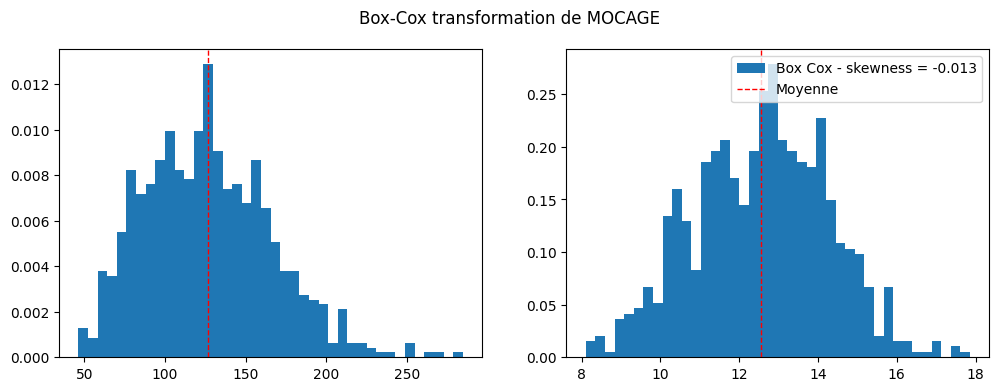

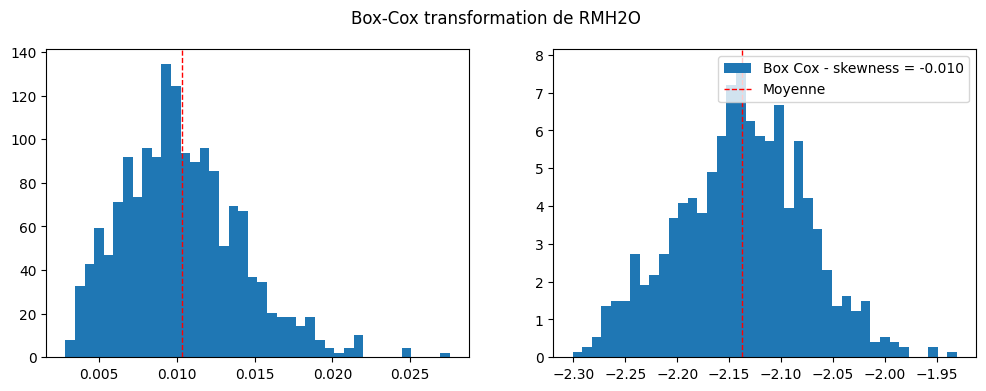

In [96]:
from scipy.stats import skew, boxcox

col_skew = ['MOCAGE', 'RMH2O'] # 03obs est la variable cible donc on la considere pas
for col in col_skew:
    mask = X_train_clean[col].notna() # on recupere un mask pour associer les nouvelles valeurs dans le bon ordre
    x = X_train_clean.loc[mask, col]
    s_before = skew(x) # score de skewness avant transformation

    x_bc, _ = boxcox(x)
    s_bc = skew(x_bc)

    fig, ax = plt.subplots(1,2, figsize=(12, 4))
    plt.suptitle(f"Box-Cox transformation de {col}")
    ax[0].hist(x, density=True, bins=40, label=f"Original - skewness = {s_before:.3f}")
    ax[0].axvline(x.mean(), color='red', linestyle='dashed', linewidth=1, label='Moyenne')
    
    ax[1].hist(x_bc, density=True, bins=40, label=f"Box Cox - skewness = {s_bc:.3f}")
    ax[1].axvline(x_bc.mean(), color='red', linestyle='dashed', linewidth=1, label='Moyenne')
     
    plt.legend()
    plt.show()

    # Au vu des améliorations, on utilise la transformation Box-Cox 
    X_train_clean.drop(columns=[col], inplace=True) # on supprime la colonne d'origine
    X_train_clean[col+'_boxcox'] = np.nan # creation de la nouvelle colonne
    X_train_clean.loc[mask, col +'_boxcox'] = x_bc 

In [97]:
test_normalite(X_train_clean[["MOCAGE_boxcox", "RMH2O_boxcox"]])

MOCAGE_boxcox - stat=0.997, p-valeur=0.079, resultat (normal ?)=True
RMH2O_boxcox - stat=0.997, p-valeur=0.077, resultat (normal ?)=True


On remarque que nos données qui avait une asymétrie ne l'ont plus et sont sous l'hypothese de normalité à présent

## Exponentielle

In [98]:
X_train_clean["logNO2"] = np.log(X_train_clean["NO2"])
X_train_clean["logNO"] = np.log(X_train_clean["NO"])

X_train_clean.drop(columns=["NO2","NO"], inplace=True)

## Valeurs aberrantes

### Normales

"For data that follows a normal distribution, the values that fall more than three standard deviations from the mean are typically considered outliers." https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

Donc on s'occupe de TEMPE, MOCAGE, RMH2O

In [99]:
# on considere uniquement les variables qui semblent suivre une loi normale
col_normale = ['TEMPE', 'MOCAGE_boxcox', 'RMH2O_boxcox'] 
Q1 = X_train_clean[col_normale].quantile(0.25)
Q3 = X_train_clean[col_normale].quantile(0.75)
IQR = Q3 - Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR
mask = (X_train_clean[col_normale]<lower) | (X_train_clean[col_normale]>upper)
is_outliers =  mask.any(axis=1) # si une variable est considéré comme aberrante
X_train_clean['outliers'] = is_outliers

In [100]:
X_train_clean[is_outliers]

JOUR      TEMPE  STATION  VentMOD   VentANG  MOCAGE_boxcox  RMH2O_boxcox  \
481     0  25.757143        2  5.45890  0.496420      12.849112     -1.930869   
682     0  38.000000        4  4.95782  0.728320      16.114948     -2.074529   
845     0  10.400000        3  8.05050 -0.112030      13.033331     -2.094566   
982     1  28.500000        3  4.14000  0.648330      17.858112     -2.185670   
225     0  19.557143        3  5.09215  0.340380      11.499257     -1.956498   
62      0  22.100000        0  5.09310  0.813170      16.340716     -1.955452   
681     0  37.400000        4  5.40370  0.319047      15.305498     -2.061172   

       logNO2     logNO  outliers  
481  0.691145 -1.514128      True  
682  2.218334 -0.102033      True  
845  0.701115 -0.685179      True  
982  0.825052 -0.800414      True  
225  0.576613 -1.145704      True  
62   2.907065  0.766862      True  
681  2.141007 -0.169603      True

On remarque qu'il y a peu d'outliers.

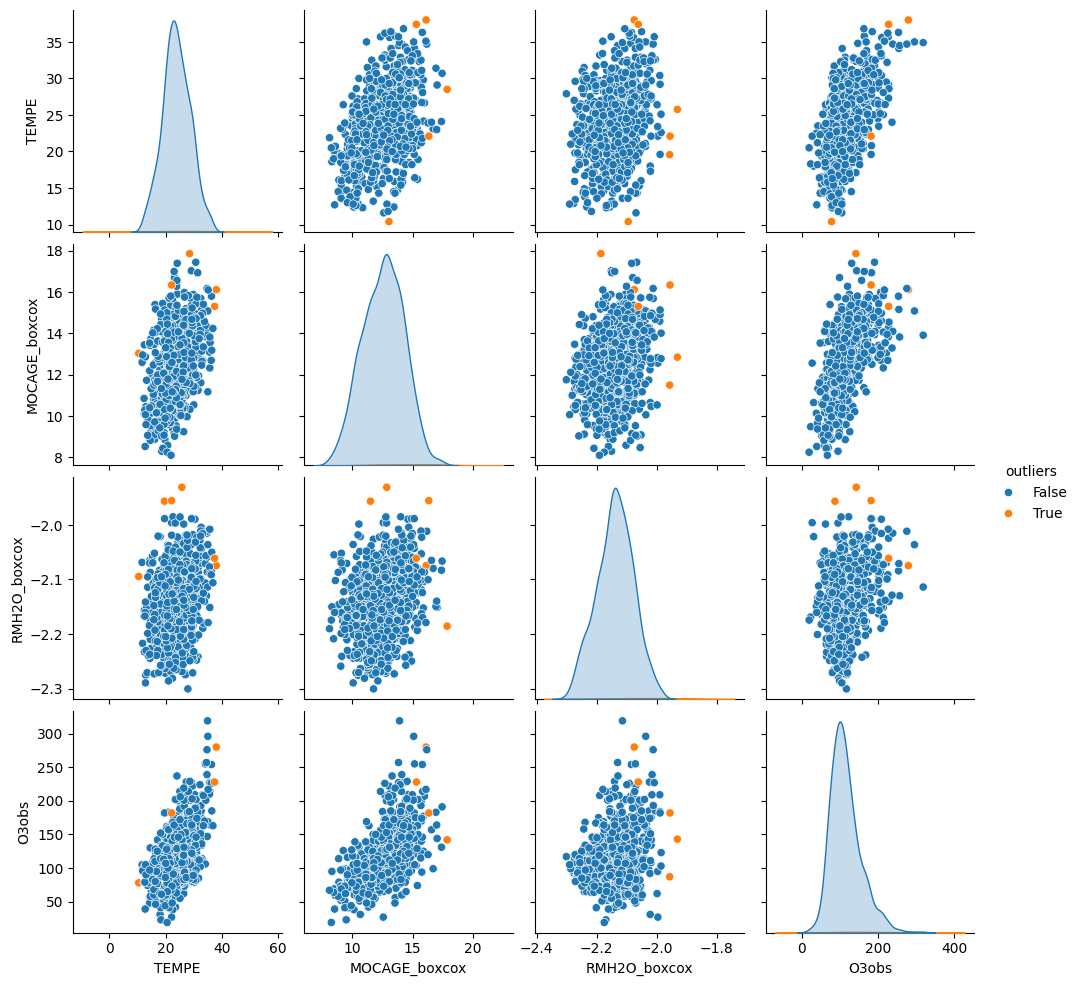

In [101]:
# sns.pairplot(data=X_train_clean,vars=col_normale,hue='outliers',diag_kind='hist')
sns.pairplot(data=pd.concat([X_train_clean, Y_train_clean], axis=1), vars=col_normale+['O3obs'], hue='outliers')

In [102]:
mask = X_train_clean['outliers']==False
Y_train_clean = Y_train_clean[mask]
X_train_clean = X_train_clean[mask].drop('outliers', axis=1)


In [103]:
len(X_train_clean), len(Y_train_clean)

(788, 788)

## Normaliser

In [104]:
col_disc = ['JOUR', 'STATION']
col_cont = [col for col in X_train_clean.columns if col not in col_disc]

In [105]:
from sklearn.preprocessing import StandardScaler, Normalizer

std_scaler = StandardScaler()
X_std = X_train_clean.copy()
X_std[col_cont] = std_scaler.fit_transform(X_train_clean[col_cont])

# Normalisation
norm_scaler = Normalizer()
X_norm = X_train_clean.copy()
X_norm[col_cont] = norm_scaler.fit_transform(X_train_clean[col_cont])

# Tests des différentes versions
print("Aucune modification")
test_model_simple(X_train_clean, Y_train_clean)
print("Standardisation") 
test_model_simple(X_std, Y_train_clean)
print("Normalisation")
test_model_simple(X_norm, Y_train_clean)


Aucune modification
KNN        RMSE: 27.672 ± 1.056
Lasso      RMSE: 28.687 ± 1.904


Ridge      RMSE: 28.555 ± 1.896
Linear     RMSE: 28.591 ± 1.872
Standardisation
KNN        RMSE: 27.598 ± 1.799
Lasso      RMSE: 28.693 ± 1.872
Ridge      RMSE: 28.588 ± 1.872
Linear     RMSE: 28.591 ± 1.872
Normalisation
KNN        RMSE: 34.415 ± 1.996
Lasso      RMSE: 40.246 ± 2.707
Ridge      RMSE: 37.875 ± 2.735
Linear     RMSE: 30.580 ± 2.336


On remarque que la plage de valeur de nos données ne sont pas dérangeante pour les manipuler dans nos modèles. Donc bien que les scores soit quasiment égaux entre la standardisation et ne rien faire, pour la stabilité numérique et une "uniformisation" des valeurs on choisit de standardiser. On remarque que la normalisation dégrade lourdement nos prédictions !

In [106]:
X_train_clean[col_cont] = pd.DataFrame(StandardScaler().fit_transform(X_train_clean[col_cont]), columns=col_cont, index=X_train_clean.index)

# Ajout de variables

On remarque que des variables sont fortement corrélées de par leur distribution conjointe ou encore par leur nom.   
Nous pouvons essayer de créer à la main des variables en faisant des combinaisons non linéaires (si linéaire alors les modèles n'auront aucun mal à les déduire). Or, nous n'avons pas plus d'affinité que ça avec la météorologie donc nous allons automatiser la chose.

Nous créons une multitude de nouvelles variables, puis à l'aide de LASSO nous sélectionnerons celles qui nous paraissent les plus pertinentes. Nous faisons de la selection de variables.

In [107]:
X_train_new = X_train_clean.copy()

In [108]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = pd.DataFrame(poly.fit_transform(X_train_new), columns=poly.get_feature_names_out(X_train_new.columns),index=X_train_new.index)
X_poly = X_poly.drop(columns=['1'])  # on supprime la premiere colonne qui est une constante

On a ainsi beuacoup de variables permettant certainement de capturer de nouvelles informations. 
Toutefois, il est sûr qu'on a des variables inutiles ou redondantes.
Par exemple, Station et Station^2 donne la meme information. Ce ne sotn que des lieux donc c'est pas en mettant au carré qu'une linearite apparaitra par rapport à o3_obs
Ensuite, Jour semble être inutile au vu du second pairplot et même au niveau de l'interprétabilité la concentration d'ozone varie probablement pas selon les jours fériés, donc il est certain que JOUR^2 peut-être supprimée.

In [109]:
print("Avec toutes les nouvelles variables")
test_model_simple(X_poly, Y_train_clean)

Avec toutes les nouvelles variables
KNN        RMSE: 27.722 ± 1.597
Lasso      RMSE: 27.733 ± 1.826
Ridge      RMSE: 27.160 ± 1.496


Linear     RMSE: 27.252 ± 1.492


# Selection de variables

## LASSO

On va procéder pour la selection de variable grâce à LASSO qui permet par sa parcimonie de sélectionner les variables selon les coefficients obtenus le long d'un chemin de lmabda (une liste de hyperparametre lambda). Les variables censées être signifiante auront des coefficients notable contrairement à des variables inutiles qui devrait être ignorés pendant l'optimisation et donc avoir un coefficient nul.

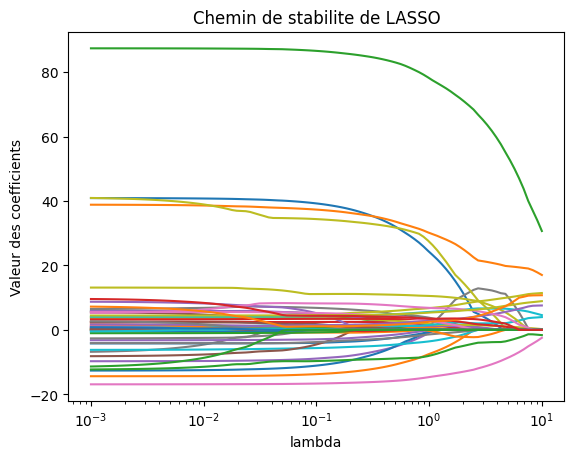

In [110]:
from sklearn.linear_model import lasso_path

alphas, coefs, _ = lasso_path(X_poly, Y_train_clean, alphas=np.logspace(-3, 1, 100))

for coef in coefs:
    plt.plot(alphas, coef)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('Valeur des coefficients')
plt.title('Chemin de stabilite de LASSO')
plt.show()


On remarque que les chemins sont relativement constants donc le critère qu'on va considérer c'est le maximum en valeur absolue. Ca voudra dire que la variable aura été relativement performante à un moment.

In [111]:
coefs_array = np.array(coefs)

for seuil in range(1, 15, 2):
    mask = np.max(np.abs(coefs_array), axis=1) > seuil # notre critere de selection
    select_var = X_poly.columns[mask]
    print(f"Seuil - {seuil} - Nombre de variables gardées : {sum(mask)} / {len(mask)}")
    X_lasso = X_poly[select_var]
    test_model_simple(X_lasso, Y_train_clean)

Seuil - 1 - Nombre de variables gardées : 45 / 54
KNN        RMSE: 27.727 ± 1.186
Lasso      RMSE: 27.696 ± 1.804
Ridge      RMSE: 26.926 ± 1.595
Linear     RMSE: 26.966 ± 1.595
Seuil - 3 - Nombre de variables gardées : 33 / 54
KNN        RMSE: 28.330 ± 1.498
Lasso      RMSE: 28.074 ± 1.737
Ridge      RMSE: 27.346 ± 1.632
Linear     RMSE: 27.373 ± 1.640
Seuil - 5 - Nombre de variables gardées : 27 / 54
KNN        RMSE: 28.668 ± 1.945
Lasso      RMSE: 27.901 ± 1.508
Ridge      RMSE: 27.259 ± 1.379
Linear     RMSE: 27.287 ± 1.388
Seuil - 7 - Nombre de variables gardées : 21 / 54
KNN        RMSE: 30.222 ± 1.952
Lasso      RMSE: 30.365 ± 2.120
Ridge      RMSE: 29.630 ± 1.744
Linear     RMSE: 29.657 ± 1.724
Seuil - 9 - Nombre de variables gardées : 15 / 54
KNN        RMSE: 30.584 ± 2.470
Lasso      RMSE: 30.547 ± 2.140
Ridge      RMSE: 29.880 ± 2.113
Linear     RMSE: 29.886 ± 2.106
Seuil - 11 - Nombre de variables gardées : 12 / 54
KNN        RMSE: 31.039 ± 2.346
Lasso      RMSE: 30.675 ± 2

In [112]:
# on choisit le seuil 1
mask = np.max(np.abs(coefs_array), axis=1) > 1 # notre critere de selection
select_var = X_poly.columns[mask]

In [113]:
print(select_var)
# on supprime les variables qui sont sures d'être inutiles
select_var =  select_var.drop(['STATION^2', 'JOUR STATION'])

Index(['JOUR', 'TEMPE', 'STATION', 'VentMOD', 'VentANG', 'MOCAGE_boxcox',
       'RMH2O_boxcox', 'logNO2', 'logNO', 'JOUR TEMPE', 'JOUR STATION',
       'JOUR VentMOD', 'JOUR MOCAGE_boxcox', 'JOUR RMH2O_boxcox',
       'JOUR logNO2', 'JOUR logNO', 'TEMPE^2', 'TEMPE STATION',
       'TEMPE VentMOD', 'TEMPE VentANG', 'TEMPE MOCAGE_boxcox',
       'TEMPE RMH2O_boxcox', 'TEMPE logNO2', 'TEMPE logNO', 'STATION^2',
       'STATION VentMOD', 'STATION VentANG', 'STATION MOCAGE_boxcox',
       'STATION logNO2', 'STATION logNO', 'VentMOD^2', 'VentMOD VentANG',
       'VentMOD MOCAGE_boxcox', 'VentMOD RMH2O_boxcox', 'VentMOD logNO2',
       'VentMOD logNO', 'VentANG^2', 'VentANG logNO2', 'MOCAGE_boxcox^2',
       'MOCAGE_boxcox logNO2', 'MOCAGE_boxcox logNO', 'RMH2O_boxcox^2',
       'logNO2^2', 'logNO2 logNO', 'logNO^2'],
      dtype='object')


In [114]:
X_train_new = X_poly[select_var]

# Modeles complexes

Il semblerait qu'on ait nettoyé, ajouté, modifié nos donées au mieux. Maintenant il est temps de passer à des modèles plus sophistiqués afin de faire de meilleur prédiction.

In [115]:
# on regarde la prediciton sur un ensemble de validation poru voir si l'erreur est "corrigeable"
X_tr, X_val, y_tr, y_val = train_test_split(X_train_new, Y_train_clean, test_size=0.2, random_state=42)

# pour visualiser on va afficher par ordre croissant les vraies valeurs o3_obs et les valeurs prédites
y_val_np = np.array(y_val)
sort_idx = np.argsort(y_val_np)
y_val_sort = y_val_np[sort_idx]

## Arbre de décision

Comme vu en cours, on divise les données selon de seuils sur un certian niveau de complexité (max_depth). Ici c'est appliqué à la regression et non à la classification en subdivisant la sortie en valeur discretes (intervalles) (et non continue)

In [116]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=4, random_state=42)
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  # Rendre les scores positifs
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

RMSE - 28.95 ± 1.12


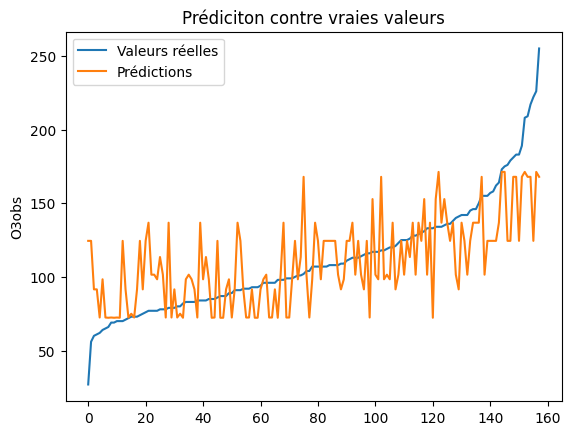

In [117]:
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

Le score et les erreurs ne sont pas prometteur. On laisse ce model de coté.
Il ne perçoit pas vraiment quand la concentration de o3_obs est basse ou non, il connait la moyenne mais est incapable de faire plus.

## Random Forest

C'est un ensemble (bootstrap) d'arbres de décision, assez commun dans le domaine de l'analyse de données et généralement performant.

In [118]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

RMSE - 26.63 ± 1.33


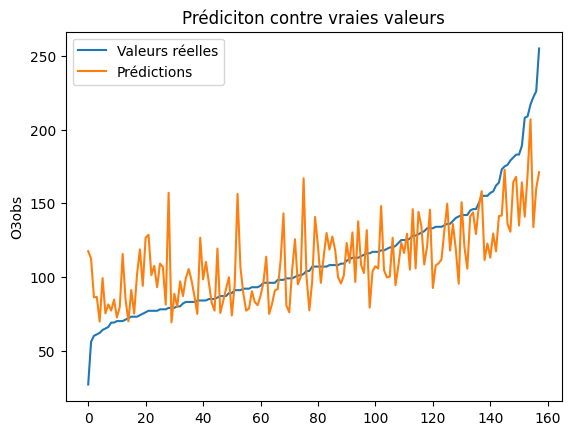

In [119]:
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

Ce modèle capture la moyenne des valeurs et sous-estime les pics de concentration d'ozone.  
Intéressant à garder pour plus tard.

## XGBoost

Encore une foret d'arbre de décision mais boostée et assez utilisé dans les compétition Kaggle

In [120]:
import xgboost as xgb

model = xgb.XGBRegressor(max_depth=4, random_state=42)
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  # Rendre les scores positifs
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

RMSE - 27.21 ± 1.38


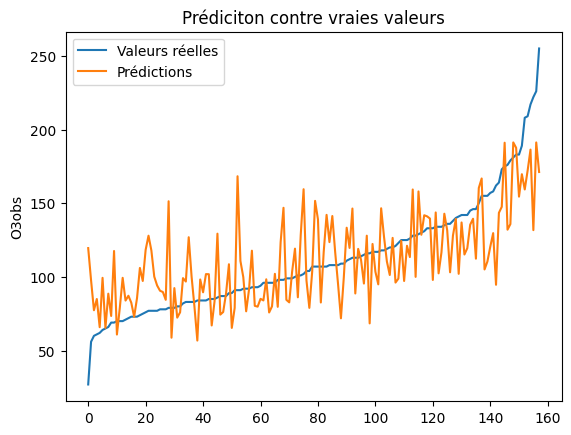

In [121]:
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

Pas de gain par rapport à une simple foret d'arbre de décision. Pas à jeter mais pas des plus pertinents.

## Processus Gaussien

On a des données d'un probleme pysique donc les aléa de la vie font que c'est cohérent de les modéliser par un apriori gaussien. De plus, les fluctuations imprévisible de o3_obs nécessite un kernel moins régulier que le classique RBF (à améliorer plus tard) par WhiteKernel

https://medium.com/data-science/gaussian-process-kernels-96bafb4dd63e

In [122]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.model_selection import cross_val_score

kernel =  RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
model = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True) # sans le normalize il y a des erreurs car le modele n'est pas stable
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  # Rendre les scores positifs
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

RMSE - 26.70 ± 1.93


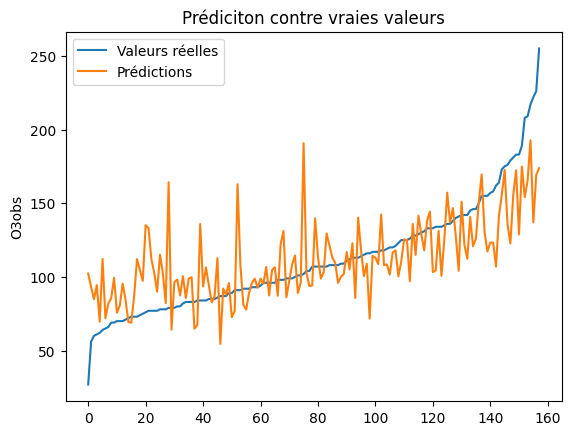

In [123]:
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

Très prometteur, capte dans l'ensemble l'idée de la valeur mais est sujet, sur de petites valeurs de o3_obs à de grandes "déviations" rendant le modèle moins performant que ce qu'il semble l'être.
Sous-estime les grandes valeurs,  sur-estiment grandement les basses valeurs.

## Autre

# Hyperparamètres

On a vu qu'au long de l'analyse que les modeles simples performent relativement bien. On va les considérer afin, quand c'est possible, d'optimiser leur(s) hyperparmaètre(s) avec les modèles précédents dits "complexes"

In [124]:
from sklearn.model_selection import GridSearchCV

## Modeles simples

### KNN Regressor

Meilleur params {'n_neighbors': 8} - RMSE : -27.82


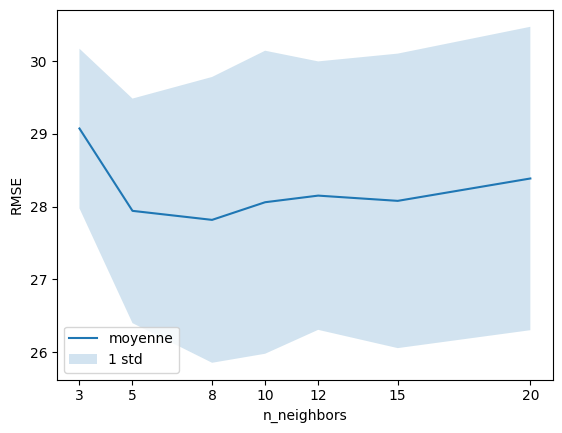

In [125]:
model = KNeighborsRegressor()

param_grid = {'n_neighbors': [3, 5, 8, 10, 12, 15, 20]}

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',return_train_score=False)
grid.fit(X_train_new, Y_train_clean)

means = -grid.cv_results_['mean_test_score']
stds=  grid.cv_results_['std_test_score']

neighbors = np.array(grid.cv_results_['param_n_neighbors'].data, dtype=int)
print(f"Meilleur params {grid.best_params_} - RMSE : {grid.best_score_:.2f}")

plt.plot(neighbors, means, label='moyenne')
plt.fill_between(neighbors,means-stds, means+stds, alpha=0.2,label='1 std')
plt.xlabel('n_neighbors')
plt.xticks([3, 5, 8, 10, 12, 15, 20])
plt.ylabel('RMSE')
plt.legend()


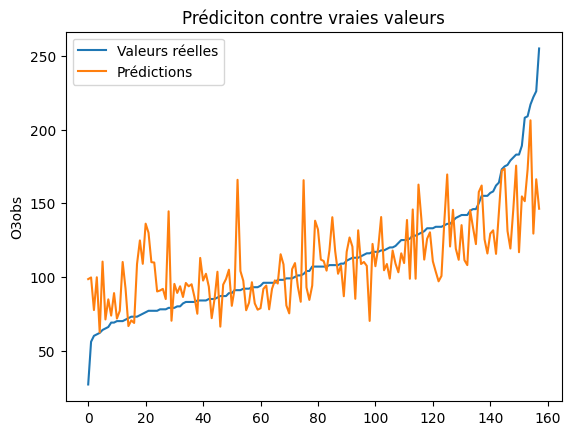

In [126]:
model = KNeighborsRegressor(n_neighbors=8,)
model.fit(X_tr, y_tr)
y_pred= model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

### Ridge

On a déjà fait de la selection de varible donc quitte à choisir entre LASSO et Ridge on prend ridge qui conserve, généralement, toutes les variables 

c:\Users\Le R\anaconda3\envs\0m4r\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+02, tolerance: 1.075e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Le R\anaconda3\envs\0m4r\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+02, tolerance: 1.007e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Le R\anaconda3\envs\0m4r\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Meilleur params {'alpha': np.float64(0.046415888336127774)} - RMSE : -27.02


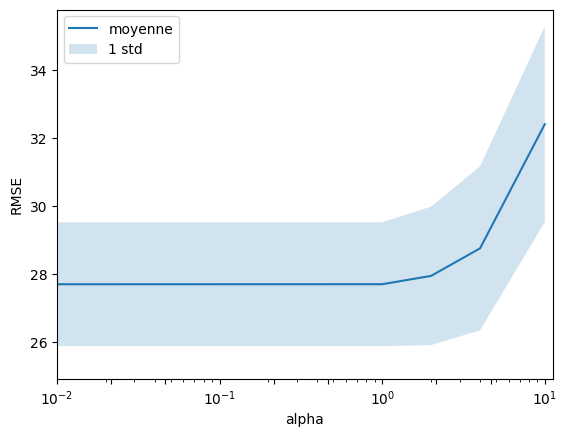

In [127]:
model = Lasso(random_state=42)
param_grid = {"alpha": np.logspace(-2,1, 10)}

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',return_train_score=False)
grid.fit(X_train_new, Y_train_clean)

means = -grid.cv_results_['mean_test_score']
stds=  grid.cv_results_['std_test_score']

neighbors = np.array(grid.cv_results_['param_alpha'].data, dtype=int)
print(f"Meilleur params {grid.best_params_} - RMSE : {grid.best_score_:.2f}")

plt.plot(neighbors, means, label='moyenne')
plt.fill_between(neighbors,means-stds, means+stds, alpha=0.2,label='1 std')
plt.xlabel('alpha')
plt.xscale("log")
plt.xticks(np.logspace(-2,1, 10))
plt.ylabel('RMSE')
plt.legend()


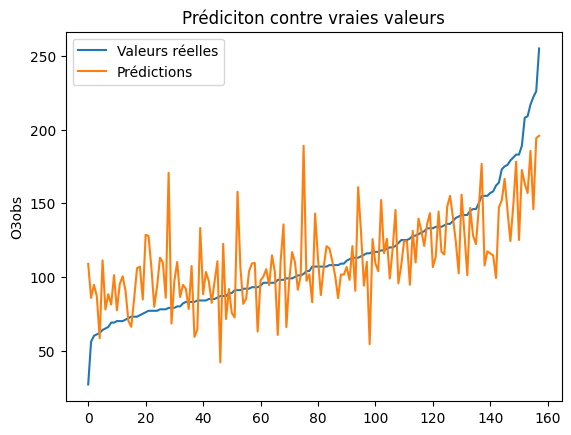

In [128]:
model = Ridge(alpha=0.0464)
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

Au vu de la faible valeur de alpha (ou lambda)(<0.05), il n'est pas nécessaire de considérer un modèle lineaire, les résultat seraient redondant.

## Modeles complexes

## Random Forest

4min d'execution !

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# Définition du modèle et des paramètres à tester
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10]
}
grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error')
grid.fit(X_train_new, Y_train_clean)

means = -grid.cv_results_['mean_test_score']
stds=  grid.cv_results_['std_test_score']

print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"RMSE : {-grid.best_score_:.3f} ± {np.mean(stds):.3f}")

Meilleurs paramètres : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
RMSE : 26.182 ± 1.128


Meilleurs paramètres : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
RMSE : 26.182 ± 1.128

## XGBoost

13h d'execution ! Ne pas executer, le résultat est en markdown

In [130]:
# model = xgb.XGBRegressor(random_state=42)
# param_grid = {
#     'n_estimators': [ 100,250,500,750],
#     'max_depth': [ 5, 8, 12],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.5, 0.75, 1],
#     'colsample_bytree': [0.7, 0.8, 1]
# }

# grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error')
# grid.fit(X_train_new, Y_train_clean)

# means = -grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']

# print(f"Meilleurs paramètres : {grid.best_params_}")
# print(f"RMSE : {-grid.best_score_:.3f} ± {np.mean(stds):.3f}")

Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 750, 'subsample': 0.5}  
RMSE : 25.473 ± 1.176


RMSE - 25.47 ± 0.96


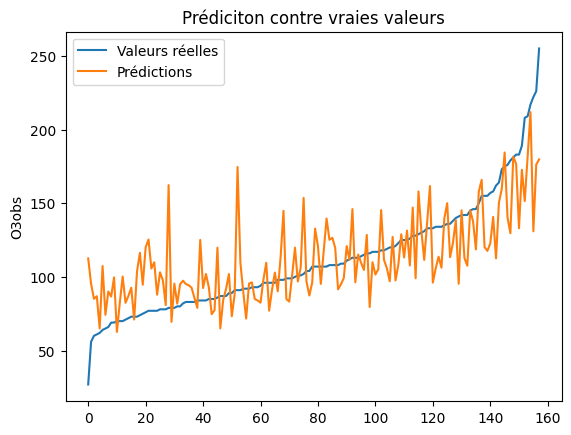

In [131]:
model = xgb.XGBRegressor(n_estimators=750, max_depth=8, learning_rate=0.01, min_child_weight=1, subsample=0.5, colsample_bytree=0.8, random_state=42)
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  # Rendre les scores positifs
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

## Processus gaussien

4h d'execution !!! Je recommande de ne pas executer. En commentaire au cas où.

In [132]:
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern, RationalQuadratic

# kernels = {
#     'RBF + White': RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
#     'RBF * Const + White': ConstantKernel() * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
#     'Matern + White': Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0),
#     'RationalQuadratic + White': RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=1.0)
# }

# for kernel_name, kernel in kernels.items():
#     print(f"kernel : {kernel_name}")

#     model = GaussianProcessRegressor(kernel=kernel, random_state=42,normalize_y=True,n_restarts_optimizer=5)
    
#     if kernel_name == 'RBF + White':
#         param_grid = {
#             'kernel__k1__length_scale': np.logspace(-1, 2, 4),
#             'kernel__k2__noise_level': np.logspace(-2, 1, 4)
#         }
#     elif kernel_name == 'RBF * Const + White':
#         param_grid = {
#             'kernel__k1__k1__constant_value': np.logspace(-1, 1, 3),
#             'kernel__k1__k2__length_scale': np.logspace(-1, 2, 4),
#             'kernel__k2__noise_level': np.logspace(-2, 1, 4)
#         }
#     elif kernel_name == 'Matern + White':
#         param_grid = {
#             'kernel__k1__length_scale': np.logspace(-1, 2, 4),
#             'kernel__k2__noise_level': np.logspace(-2, 1, 4)
#         }
#     else:  # RationalQuadratic
#         param_grid = {
#             'kernel__k1__length_scale': np.logspace(-1, 2, 4),
#             'kernel__k1__alpha': np.logspace(-1, 1, 3),
#             'kernel__k2__noise_level': np.logspace(-2, 1, 4)
#         }

#     grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error')
    
#     grid.fit(X_train_new, Y_train_clean)
#     means = -grid.cv_results_['mean_test_score']
#     stds = grid.cv_results_['std_test_score']
    
#     print(f"Ce kernel - {grid.best_estimator_.kernel_} - ces paramètres - {grid.best_params_} ")
#     print(f"RMSE : {-grid.best_score_:.2f} ± {np.mean(stds):.2f}")

kernel : **RBF + White**
Ce kernel - RBF(length_scale=11.5) + WhiteKernel(noise_level=0.395) - ces paramètres - {'kernel__k1__length_scale': np.float64(10.0), 'kernel__k2__noise_level': np.float64(10.0)}   
RMSE : **26.70** ± 1.93

kernel : **RBF * Const + White**
Ce kernel - 1.08**2 * RBF(length_scale=12.2) + WhiteKernel(noise_level=0.395) - ces paramètres - {'kernel__k1__k1__constant_value': np.float64(10.0), 'kernel__k1__k2__length_scale': np.float64(1.0), 'kernel__k2__noise_level': np.float64(0.1)}   
RMSE : **26.75** ± 2.27

kernel : **Matern + White**
Ce kernel - Matern(length_scale=15.5, nu=1.5) + WhiteKernel(noise_level=0.363) - ces paramètres - {'kernel__k1__length_scale': np.float64(100.0), 'kernel__k2__noise_level': np.float64(1.0)}   
RMSE : **26.32** ± 1.87

kernel : **RationalQuadratic + White**
Ce kernel - RationalQuadratic(alpha=1.28, length_scale=11.2) + WhiteKernel(noise_level=0.383) - ces paramètres - {'kernel__k1__alpha': np.float64(1.0), 'kernel__k1__length_scale': np.float64(0.1), 'kernel__k2__noise_level': np.float64(10.0)}   
RMSE : **26.60** ± 1.95

RMSE - 26.32 ± 1.87


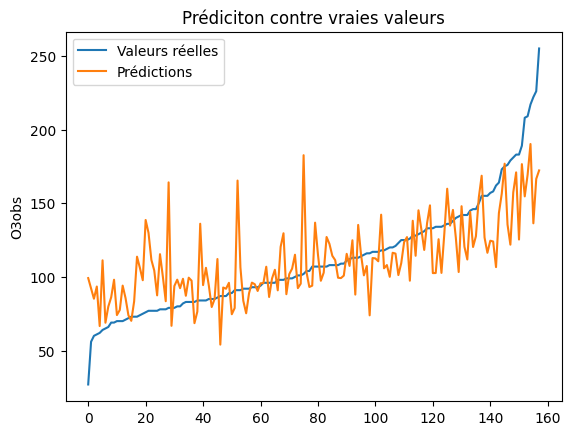

In [133]:
from sklearn.gaussian_process.kernels import Matern

kernel = Matern(length_scale=15.5, nu=1.5) + WhiteKernel(noise_level=0.363)
model = GaussianProcessRegressor(kernel=kernel,random_state=42,normalize_y=True)
rmse = cross_val_score(model, X_train_new, Y_train_clean, cv=5, scoring='neg_root_mean_squared_error')
rmse = -rmse  # Rendre les scores positifs
print(f"RMSE - {rmse.mean():.2f} ± {rmse.std():.2f}")

model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

y_pred_sort= y_pred[sort_idx]

plt.plot(y_val_sort, label='Valeurs réelles')
plt.plot(y_pred_sort, label='Prédictions')
plt.ylabel("O3obs")
plt.title("Prédiciton contre vraies valeurs")
plt.legend()

# Modeles final

## Stacking

On conclu en fin toute notre analyse avec une proposition de modèle final. 
On a obtenu plusieurs modèles agissant de manière différentes sur nos données donc on créer un "meta-modele" consistant à prédire un meilleur score selon ce que les autres prédisent.
Exemple : si un modèle sur-estime la valeru finale et qu'un autre sous-estime alors faire un meta-modele qui fait une moyenne des deux fera probablement un meilleur score.

Peut prendre un certain temps (10min)

In [134]:
from sklearn.ensemble import StackingRegressor

# Nos précédents modèles avec leur hyperparametres
estimators = [
    ('knn', KNeighborsRegressor(n_neighbors=8)),
    ('ridge', Ridge(alpha=0.0464, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror',n_estimators=750, max_depth=8, learning_rate=0.01, min_child_weight=1, subsample=0.5, colsample_bytree=0.8,random_state=42)),
    ('gpr', GaussianProcessRegressor(kernel=Matern(length_scale=15.5, nu=1.5) + WhiteKernel(noise_level=0.363),normalize_y=True, random_state=42))
]

# on considere un estimateur final simple comme Ridge afin de minismier l'erreur et biais
model = StackingRegressor(estimators=estimators,final_estimator=Ridge(random_state=42), cv=5)

rmse = -cross_val_score(model,X_train_new,Y_train_clean,cv=5,scoring='neg_root_mean_squared_error',).mean()
print(f"RMSE - {rmse:.2f} ± {rmse.std():.2f}")

RMSE - 25.34 ± 0.00


Le score est le meilleur qu'on ait obtenu jusque là et est justifié par toutes les précédentes remarques.

Ca sera notre model final.

In [135]:
model_final = model

In [136]:
model_final

StackingRegressor(cv=5,
                  estimators=[('knn', KNeighborsRegressor(n_neighbors=8)),
                              ('ridge', Ridge(alpha=0.0464, random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=750, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('gpr',
                               GaussianProcessRegressor(kernel=Matern(length_scale=15.5, nu=1.5) + WhiteKernel(noise_level=0.363),
                                                        normalize_y=True,
                                                        random_state=42))],
                  final_estimator=Ridge(random_state=42))

## Evaluation finale

### Traitement des données

In [137]:
def traitement(X_train, Y_train,X_test,  Y_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    Y_tr = Y_train.copy()
    Y_te = Y_test.copy()

    col_disc = ['JOUR', 'STATION']
    col_cont = [c for c in X_tr.columns if c not in col_disc]

    le = LabelEncoder()
    not_na = X_tr['STATION'].notna()
    X_tr.loc[not_na,'STATION'] = le.fit_transform(X_tr.loc[not_na,'STATION'])
    te_not_na = X_te['STATION'].notna()
    X_te.loc[te_not_na,'STATION'] = le.transform(X_te.loc[te_not_na,'STATION'])


    imputer = KNNImputer(n_neighbors=7)
    X_tr[col_cont+col_disc] = imputer.fit_transform(X_tr[col_cont+col_disc])
    X_te[col_cont+col_disc] = imputer.transform(X_te[col_cont+col_disc])
 
    X_tr[col_disc] = X_tr[col_disc].round().astype(int)
    X_te[col_disc] = X_te[col_disc].round().astype(int)


    log_col = ["NO2","NO"]
    for col in log_col:
        X_tr[f'log{col}'] = np.log(X_tr[col])
        X_te[f'log{col}'] = np.log(X_te[col])
    X_tr.drop(columns=log_col, inplace=True)
    X_te.drop(columns=log_col, inplace=True)

    bc_lambdas = {}
    for col in ["MOCAGE","RMH2O"]:
        mask = X_tr[col]>0
        vals, lam = boxcox(X_tr.loc[mask,col])
        X_tr.loc[mask, col+'_bc'] = vals
        bc_lambdas[col] = lam

        mask_te = X_te[col]>0
        X_te.loc[mask_te, col+'_bc'] = boxcox(X_te.loc[mask_te,col], lmbda=lam)

        X_tr.drop(columns=[col], inplace=True)
        X_te.drop(columns=[col], inplace=True)

    norm_cols = ['TEMPE'] + [c for c in X_tr.columns if c.endswith('_bc')]
    Q1 = X_tr[norm_cols].quantile(0.25)
    Q3 = X_tr[norm_cols].quantile(0.75)
    IQR = Q3 - Q1
    good = ~((X_tr[norm_cols] < (Q1-1.5*IQR)) | (X_tr[norm_cols] > (Q3+1.5*IQR))).any(axis=1)
    X_tr, Y_tr = X_tr.loc[good], Y_tr.loc[good]

    cont_cols = [c for c in X_tr.columns if c not in col_disc]
    scaler = StandardScaler()
    X_tr[cont_cols] = scaler.fit_transform(X_tr[cont_cols])
    X_te[cont_cols] = scaler.transform(X_te[cont_cols])

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_tr_new = pd.DataFrame(
        poly.fit_transform(X_tr),
        columns=poly.get_feature_names_out(X_tr.columns),
        index=X_tr.index
    )
    X_te_new = pd.DataFrame(
        poly.transform(X_te),
        columns=X_tr_new.columns,
        index=X_te.index
    )

    mask_y = Y_tr.notna() & np.isfinite(Y_tr)
    X_tr_new, Y_tr = X_tr_new.loc[mask_y], Y_tr.loc[mask_y]

    mask_yt = Y_te.notna() & np.isfinite(Y_te)
    X_te_new, Y_te = X_te_new.loc[mask_yt], Y_te.loc[mask_yt]
    return X_tr_new, Y_tr, X_te_new, Y_te


In [138]:
# on reprend nos données comme si on venait de charger le csv
X_train, X_test = train_test_split(df,test_size=0.2, random_state=42)

# On récupère la colonne cible O3obs
Y_train = X_train['O3obs']
Y_test = X_test['O3obs']

X_train = X_train.drop('O3obs', axis=1)
X_test = X_test.drop('O3obs', axis=1)

In [139]:
X_train_f, Y_train_f, X_test_f, Y_test_f = traitement(X_train, Y_train, X_test, Y_test)

In [140]:
def final_prediction(X_train, Y_train, X_test, Y_test, model):
    Y_train_bc, lambda_param = boxcox(Y_train)

    model.fit(X_train, Y_train_bc)
    y_pred_bc = model.predict(X_test)

    from scipy.special import inv_boxcox
    y_pred_original = inv_boxcox(y_pred_bc, lambda_param)
    
    rmse = np.sqrt(((y_pred_original - Y_test)**2).mean())
    print(f"RMSE finale - {rmse:.2f}")
    
    return y_pred_original

In [141]:
final_prediction(X_train_f, Y_train_f, X_test_f, Y_test_f, model_final)

RMSE finale - 29.19


array([154.09400026,  75.98510168, 134.75869755, 132.00489566,
       128.0860133 , 121.227483  ,  78.87752542, 106.72143387,
       165.43025848, 138.01796676,  97.5265007 , 181.24684402,
       119.04979198, 100.64409516, 170.98872768,  91.28821577,
       114.23965018, 149.50912381,  96.45753251, 114.94441156,
        87.76579245,  84.1313788 ,  85.70155056, 114.72064444,
       174.11590765, 115.61011234,  86.29006191,  79.58213718,
        94.38601024,  90.22906788, 116.11753048, 121.26936018,
       118.61710856, 117.52779864, 122.25801512, 170.52148119,
       144.34325371, 140.58146984, 145.20190078,  83.93871694,
       155.77611455,  85.88702611,  66.83051814,  84.00605631,
       183.93053827, 119.52273616, 114.57289262,  85.90445436,
        89.51039662, 148.72795984,  88.90200434, 123.77729353,
       127.31058173, 127.1744513 , 104.69860678,  85.6552528 ,
       117.78967696, 127.46550081,  73.13333761, 167.43806782,
       119.05531483,  61.50103949,  85.12327178, 106.81

On a donc un score final de RMSE sur l'ensemble de test de **29.19**
Certainement améliorable mais pas mal.

### Comparaison avec l'approche directe (naïve, rapide, ...)

A titre de comparaison, si on avait considéré que les modèles simples sur un ensemble d'entrainement sans analyse on aurait eu ce résultat.

In [142]:
def traitement_direct(X_train, Y_train, X_test, Y_test):
    
    mask = X_train['STATION'].notna() # on garde les NaN
    label_encoder = LabelEncoder()
    X_train.loc[mask, 'STATION'] = label_encoder.fit_transform(X_train.loc[mask,'STATION'])
    
    mask = X_test['STATION'].notna()
    X_test.loc[mask, 'STATION'] = label_encoder.transform(X_test.loc[mask,'STATION'])


    valid_tr = Y_train.notna() & X_train.notna().all(axis=1)
    valid_te = Y_test.notna()  & X_test.notna().all(axis=1)
    
    X_tr_f = X_train.loc[valid_tr].reset_index(drop=True)
    Y_tr_f = Y_train.loc[valid_tr].reset_index(drop=True)
    X_te_f = X_test.loc[valid_te].reset_index(drop=True)
    Y_te_f = Y_test.loc[valid_te].reset_index(drop=True)
    
    return X_tr_f, Y_tr_f, X_te_f, Y_te_f
    

In [143]:
X_train_f, Y_train_f, X_test_f, Y_test_f = traitement_direct(X_train, Y_train, X_test, Y_test)

In [144]:
models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Linear': LinearRegression()
}

for name, model in models.items():
    model.fit(X_train_f, Y_train_f)
    y_pred = model.predict(X_test_f)
    rmse = np.sqrt(((y_pred - Y_test_f)**2).mean())

    print(f'{name} - RMSE : {rmse:.2f}')

    

KNN - RMSE : 31.93
Lasso - RMSE : 30.18
Ridge - RMSE : 29.28
Linear - RMSE : 29.28


# Au delà ?

Au terme de ce projet, nous avons mené une démarche complète de modélisation, de l’exploration et la préparation des données jusqu’à la mise en œuvre et l’optimisation de modèles complexes (Random Forest, XGBoost, StackingRegressor...). Nous avons systématiquement testé et ajusté les hyperparamètres afin d’obtenir les meilleurs résultats possibles.

Malgré toutes ces étapes et l’utilisation de méthodes avancées, le gain en performance est très limité ! On a fait que très légèrement mieux qu'un modèle linéaire entrainé sur des données sans traitement...

Par manque de temps, nous n'avons pas pu fiare toutes les analyses que nous souhaitons faire. Voici une liste non exhaustive de chose à examiner pour améliorer la prédiction.


+ Rajouter des variables selon NO, NO2 et VentANG, vent[...]
+ Verifier par des tests statistiques que les 2 variables considérées comme exponentielle.
+ Matrice de corrélation
+ PCA
+ Generer + de données avec une faible concentration de o3_obs
+ Optimisaiton de StackRegressor
+ Utiliser d'autres modèles de regression